In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
__d = pd.read_csv(
    "salmon/io/2021-07-01-arr-search/ARR-n_search=352440-n_top=1-1_responses.csv.zip"
)
__d = __d[__d.score >= -1000]
__d[["head", "left", "right"]].to_csv("/Users/scott/Downloads/__tmp.csv", index=False)

In [3]:
BASE = Path("salmon") / "io"
DIR = BASE /  "2021-05-26-search"

dfs = {}
for f in DIR.glob("*_responses.csv.zip"):
    _df = pd.read_csv(f)
    _df["fname"] = f.name
    _df["search"] = "tste"
    dfs[("tste", f.name)] = _df

DIR = BASE / "2021-07-01-arr-search"
for f in DIR.glob("*_responses.csv.zip"):
    _df = pd.read_csv(f)
    _df["fname"] = f.name
    _df["search"] = "arr"
    dfs[("arr", f.name)] = _df

(0.5, 1.0)

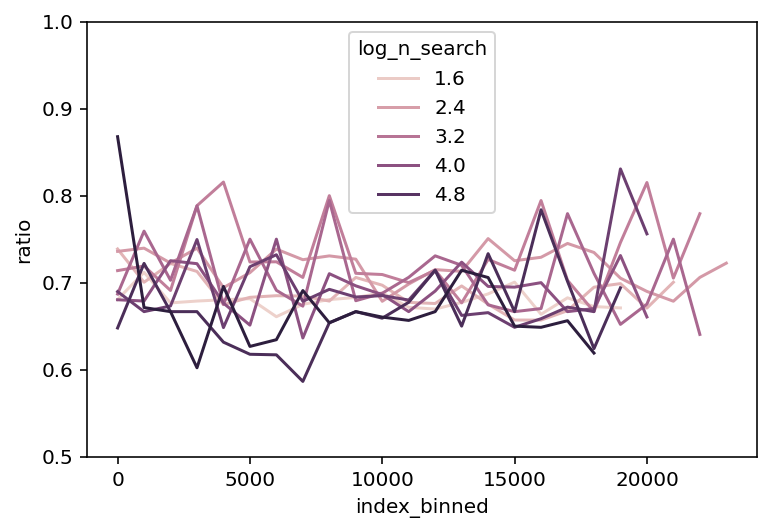

In [4]:
import seaborn as sns
_df = pd.concat(list(dfs.values()))
_df["index"] = _df.index.to_numpy()
N = 1000
_df["index_binned"] = (_df["index"] / N).astype(int) * N
_df = _df[_df.score > -100]
dl = np.abs(_df["left_filename"] - _df["head_filename"])
dr = np.abs(_df["right_filename"] - _df["head_filename"])
_df["log_n_search"] = np.log10(_df["n_search"])
_df["ratio"] = np.maximum(dl, dr) / (dl + dr)

ax = sns.lineplot(
    x="index_binned",
    y="ratio",
    hue="log_n_search",
    estimator=lambda x: np.percentile(x, 45),
    data=_df[_df.search == "tste"],
    ci=None,
)

ax.set_ylim(0.5, 1)
# fig, ax = plt.subplots()

# for (search, fname), df in dfs.items():
#     print(fname)
#     if not (search == "tste"):
#         continue
# #     if not (search == "arr" and "n_top=1" in fname and "n_search=352440" in fname):
# #         continue
# #     if not (search == "tste" and "n_search=300000" in fname):
# #         continue
        
#     _ = show.rolling(window=90 * 20, on="index")["ratio"].median().plot(ax=ax)

# ax.set_ylim(0.5, 1)

In [5]:
from ast import literal_eval

def _get_runs(df, col="head"):
    df = df[df.score >= -1000]
    same_head = (np.abs(df[col].diff()) == 0)
    runs = []
    run = 1
    for sh in same_head:
        if sh:
            run += 1
        else:
            runs.append(run)
            run = 1
    return runs

def _get_runs_query(df):
    df = df[df.score >= -1000]
    H = df["head"]
    L = df["left"]
    R = df["right"]
    runs = []
    run = 1
    last_q = {}
    for h, l, r in zip(H, L, R):
        if h in last_q or l in last_q or r in last_q:
            run += 1
        else:
            runs.append(run)
            run = 1
        last_q = {h, l, r}
    return runs

def get_runs(df, head_only=True, **kwargs):
    if head_only:
        runs = _get_runs(df, col="head")
    else:
        runs = _get_runs_query(df)
    ret = {
        "head_only": head_only,
        "runs__median": np.median(runs),
        "runs__mean": np.mean(runs),
        "runs__max": np.max(runs),
        "runs__min": np.min(runs),
        **kwargs
    }
    ret.update({f"runs__p{p}": np.percentile(runs, p) for p in np.arange(100)})
    return ret

def _get_dists(df):
    df = df[df.score >= -1000]
    dl = np.abs(df["left_html"] - df["head_html"])
    dr = np.abs(df["right_html"] - df["head_html"])
    ratio = np.maximum(dl, dr) / (dl + dr)
    ratio = ratio.iloc[-100:]
    return {
        "ratio__mean": ratio.mean(),
        "ratio__median": np.median(ratio),
        "ratio__std": np.std(ratio),
        "ratio__iqr": np.percentile(ratio, 75) - np.percentile(ratio, 25),
    }

def _get_meta(fname):
    fname = fname.replace("TSTE-", "").replace("ARR-", "").replace("-1_responses.csv.zip", "")
    fname = fname.replace("-", ",")
    
    meta = f"dict({fname})"
    meta = eval(meta)
    return {"clean_fname": fname, **meta}
    
out = []
for (search, fname), df in dfs.items():
    head_only = True if "TSTE" in fname else False
    head_only = False
    print(head_only, search, fname)
    df["index"] = np.arange(len(df))
    datum = get_runs(df, search=search, fname=fname, head_only=head_only)
    datum.update(_get_dists(df))
    datum.update(_get_meta(fname))
    out.append(datum)

False tste TSTE-n_search=10000-1_responses.csv.zip
False tste TSTE-n_search=3000-1_responses.csv.zip
False tste TSTE-n_search=100-1_responses.csv.zip
False tste TSTE-n_search=300000-1_responses.csv.zip
False tste TSTE-n_search=300-1_responses.csv.zip
False tste TSTE-n_search=1000-1_responses.csv.zip
False tste TSTE-n_search=30-1_responses.csv.zip
False tste TSTE-n_search=100000-1_responses.csv.zip
False tste TSTE-n_search=30000-1_responses.csv.zip
False arr ARR-n_search=10000-n_top=1-1_responses.csv.zip
False arr ARR-n_search=352440-n_top=30-1_responses.csv.zip
False arr ARR-n_search=352440-n_top=3-1_responses.csv.zip
False arr ARR-n_search=3000-n_top=1-1_responses.csv.zip
False arr ARR-n_search=352440-n_top=1-1_responses.csv.zip
False arr ARR-n_search=352440-n_top=300-1_responses.csv.zip
False arr ARR-n_search=352440-n_top=100-1_responses.csv.zip
False arr ARR-n_search=100000-n_top=1-1_responses.csv.zip
False arr ARR-n_search=30000-n_top=1-1_responses.csv.zip
False arr ARR-n_search=35

In [6]:
show = pd.DataFrame(out)

In [7]:
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
save_kwargs = dict(bbox_inches="tight", dpi=300, transparent=True)

In [8]:
show.columns

Index(['head_only', 'runs__median', 'runs__mean', 'runs__max', 'runs__min',
       'search', 'fname', 'runs__p0', 'runs__p1', 'runs__p2',
       ...
       'runs__p97', 'runs__p98', 'runs__p99', 'ratio__mean', 'ratio__median',
       'ratio__std', 'ratio__iqr', 'clean_fname', 'n_search', 'n_top'],
      dtype='object', length=114)

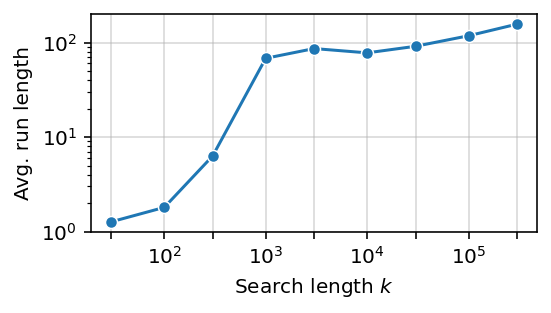

In [10]:

w = 2
fig, ax = plt.subplots(figsize=(2 * w, w))

idx = show.fname.apply(lambda x: "TSTE" in x) | (show.n_top == 1)
__s = show[idx].copy()
__s["Search"] = __s["search"].apply(lambda x: "Round robin" if x == "arr" else "Greedy")
ax = sns.lineplot(
    data=__s,
    x="n_search",
    y="runs__mean",
    hue="Search",
    hue_order=["Greedy"],
    marker="o",
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(alpha=0.5)
locs = [[1 * f, 3 * f] for f in [1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]]
ax.xaxis.set_major_locator(plt.FixedLocator(sum(locs, [])))
# ax.set_ylim(0, None)
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:0.0E}"))
ax.xaxis.set_minor_locator(plt.FixedLocator([]))
ax.set_ylabel("Avg. run length")
# ax.set_title("Same item in consecutive queries")
ax.set_xlabel("Search length $k$");
ax.legend(loc=(1.05, 0))
ax.legend_.remove()
fig.savefig("figures/query_runs.png", **save_kwargs)

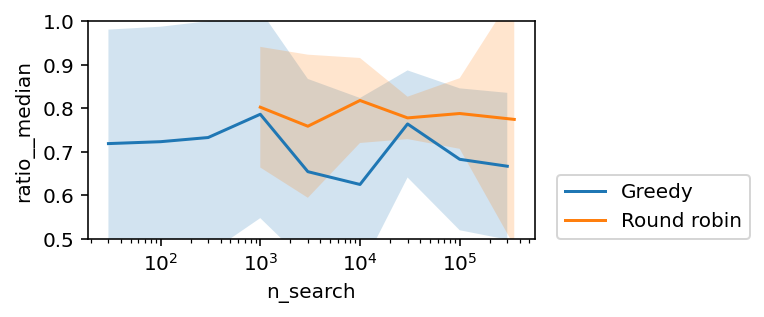

In [11]:
idx = show.fname.apply(lambda x: "TSTE" in x) | (show.n_top == 1)
__s = show[idx].copy()
__s["Search"] = __s["search"].apply(lambda x: "Round robin" if x == "arr" else "Greedy")

w = 2
fig, ax = plt.subplots(figsize=(2 * w, w))

ax = sns.lineplot(
    data=__s,
    x="n_search",
    y="ratio__median",
    hue="Search",
    estimator="mean",
)

x = "n_search"
y = "ratio__median"
__t = __s.sort_values(by=x)
assert len(__t) == len(__s)
for search in ["Greedy", "Round robin"]:
    __u = __t[__t.Search == search].sort_values(by=x)
    ax.fill_between(
        __u[x].to_numpy(),
        __u[y] - __u["ratio__iqr"].to_numpy(),
        __u[y] + __u["ratio__iqr"].to_numpy(),
        alpha=0.2,
    )
# ax.set_yscale("log")
ax.set_ylim(0.5, 1)
ax.set_xscale("log")
# ax.grid(alpha=0.5)
# locs = [[1 * f, 3 * f] for f in [1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]]
# ax.xaxis.set_major_locator(plt.FixedLocator(sum(locs, [])))
# # ax.set_ylim(0, None)
# # ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:0.0E}"))
# ax.xaxis.set_minor_locator(plt.FixedLocator([]))
# ax.set_ylabel("Avg. run length")
# ax.set_title("Same item in consecutive queries")
# ax.set_xlabel("# of queries searched\nper iteration");
ax.legend(loc=(1.05, 0))
# fig.savefig("figs3/query_runs.png", **save_kwargs)

In [12]:
__s.columns

Index(['head_only', 'runs__median', 'runs__mean', 'runs__max', 'runs__min',
       'search', 'fname', 'runs__p0', 'runs__p1', 'runs__p2',
       ...
       'runs__p98', 'runs__p99', 'ratio__mean', 'ratio__median', 'ratio__std',
       'ratio__iqr', 'clean_fname', 'n_search', 'n_top', 'Search'],
      dtype='object', length=115)

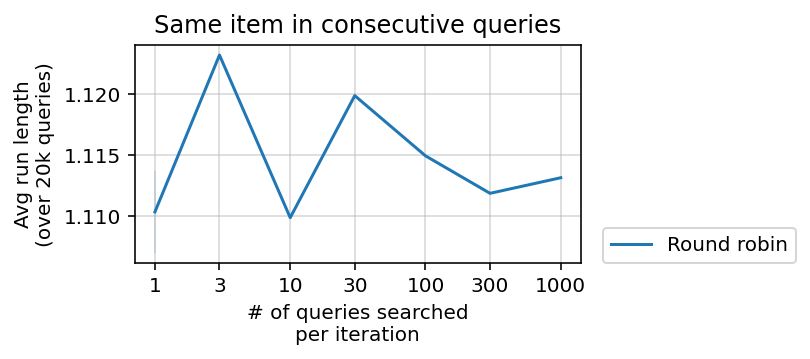

In [13]:

w = 2
fig, ax = plt.subplots(figsize=(2 * w, w))

idx = show.fname.apply(lambda x: "ARR" in x)
__s = show[idx].copy()
__s["Search"] = __s["search"].apply(lambda x: "Round robin" if x == "arr" else "Greedy")
ax = sns.lineplot(
    data=__s,
    x="n_top",
    y="runs__mean",
    hue="Search",
    estimator="mean",
)
# ax.set_yscale("log")
ax.set_xscale("log")
# ax.set_ylim(0, 16)
ax.grid(alpha=0.5)
ax.set_ylabel("Avg run length\n(over 20k queries)")
ax.set_title("Same item in consecutive queries")
ax.set_xlabel("# of queries searched\nper iteration");
ax.legend(loc=(1.05, 0))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: str(x)))
ax.xaxis.set_major_locator(plt.FixedLocator([1, 3, 10, 30, 100, 300, 1000]))
ax.xaxis.set_minor_locator(plt.FixedLocator([]))
# fig.savefig("figs3/query_runs.png", **save_kwargs)

In [14]:
def _get_random_query(n, rng):
    return rng.choice(n, replace=False, size=3)

rng = np.random.RandomState(42)
random_queries = [_get_random_query(90, rng) for _ in range(10_000)]
dists = [(abs(h - l), abs(h - r)) for h, l, r in random_queries]
ratios = [max(dl, dr) / (dl + dr) for dl, dr in dists]

random_data = {
    "ratio__p25": np.percentile(ratios, 25),
    "ratio__median": np.median(ratios),
    "ratio__p75": np.percentile(ratios, 75),
    "ratio__mean": np.mean(ratios),
}

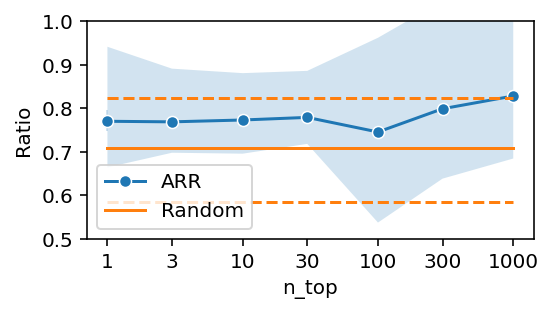

In [15]:
w = 2
fig, ax = plt.subplots(figsize=(2 * w, w))

idx = show.fname.apply(lambda x: "ARR" in x)
__s = show[idx].copy()
__s["Search"] = __s["search"].apply(lambda x: "Round robin" if x == "arr" else "Greedy")
ax = sns.lineplot(
    data=__s,
    x="n_top",
    y="ratio__mean",
    estimator="mean",
    marker="o",
    label="ARR",
)

x = "n_top"
y = "ratio__median"
y2 = "ratio__iqr"
__t = __s.sort_values(by=x)
ax.fill_between(
    __t[x].to_numpy(),
    __t[y] - __t["ratio__iqr"].to_numpy(),
    __t[y] + __t["ratio__iqr"].to_numpy(),
    alpha=0.2,
)

_x = [1, 1000]
_y = random_data["ratio__mean"]
ax.plot(_x, [_y, _y], "C1-", label="Random")
_y = random_data["ratio__p25"]
ax.plot(_x, [_y, _y], "C1--")
_y = random_data["ratio__p75"]
ax.plot(_x, [_y, _y], "C1--")

ax.legend(loc="lower left")
ax.set_ylabel("Ratio")
ax.set_xlabel("n_top")
ax.set_ylim(0.5, 1)
ax.set_xscale("log")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: str(x)))
ax.xaxis.set_major_locator(plt.FixedLocator([1, 3, 10, 30, 100, 300, 1000]))
ax.xaxis.set_minor_locator(plt.FixedLocator([]))


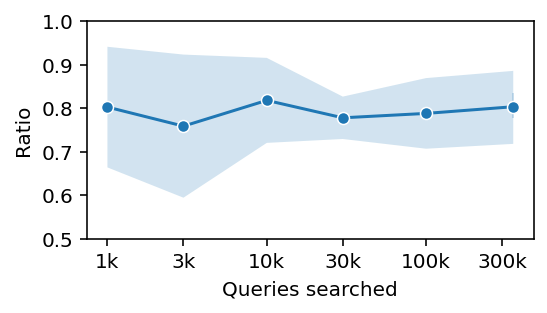

In [16]:
w = 2
fig, ax = plt.subplots(figsize=(2 * w, w))

idx = show.fname.apply(lambda x: "ARR" in x)
__s = show[idx].copy()
__s["Search"] = __s["search"].apply(lambda x: "Round robin" if x == "arr" else "Greedy")
ax = sns.lineplot(
    data=__s,
    x="n_search",
    y="ratio__median",
    estimator="mean",
    marker="o",
)

x = "n_search"
y = "ratio__median"
y2 = "ratio__iqr"
__t = __s.sort_values(by=x)
ax.fill_between(
    __t[x].to_numpy(),
    __t[y] - __t["ratio__iqr"].to_numpy(),
    __t[y] + __t["ratio__iqr"].to_numpy(),
    alpha=0.2,
)

ax.set_ylabel("Ratio")
ax.set_xlabel("Queries searched")
ax.set_ylim(0.5, 1)
ax.set_xscale("log")
searches = [1, 3, 10, 30, 100, 300, 1000, 3000, 10_000, 30_000, 100_000, 300_000]

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x//1000}k"))
ax.xaxis.set_major_locator(plt.FixedLocator(searches))
ax.xaxis.set_minor_locator(plt.FixedLocator([]))